Dataset: https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231/data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/drive/MyDrive/proyek machine learning/proyek time series prediction(LSTM)/GOOGL_2006-01-01_to_2018-01-01.csv')
df

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL
...,...,...,...,...,...,...,...
3014,2017-12-22,1070.00,1071.72,1067.64,1068.86,889446,GOOGL
3015,2017-12-26,1068.64,1068.86,1058.64,1065.85,918767,GOOGL
3016,2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,GOOGL
3017,2017-12-28,1062.25,1064.84,1053.38,1055.95,994249,GOOGL


In [3]:
df.head(10)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL
5,2006-01-10,232.44,235.36,231.25,235.11,9104719,GOOGL
6,2006-01-11,235.87,237.79,234.82,236.05,9008664,GOOGL
7,2006-01-12,237.10,237.73,230.98,232.05,10125212,GOOGL
8,2006-01-13,232.39,233.68,231.04,233.36,7660220,GOOGL
9,2006-01-17,231.76,235.18,231.50,233.79,8335300,GOOGL


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3019 non-null   datetime64[ns]
 1   Open    3019 non-null   float64       
 2   High    3019 non-null   float64       
 3   Low     3019 non-null   float64       
 4   Close   3019 non-null   float64       
 5   Volume  3019 non-null   int64         
 6   Name    3019 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 165.2+ KB


In [6]:
df.duplicated().sum()

0

In [7]:
df = df[['Date', 'Close']]
df = df.set_index('Date')

Text(0.5, 1.0, 'Close Price of GOOGLE')

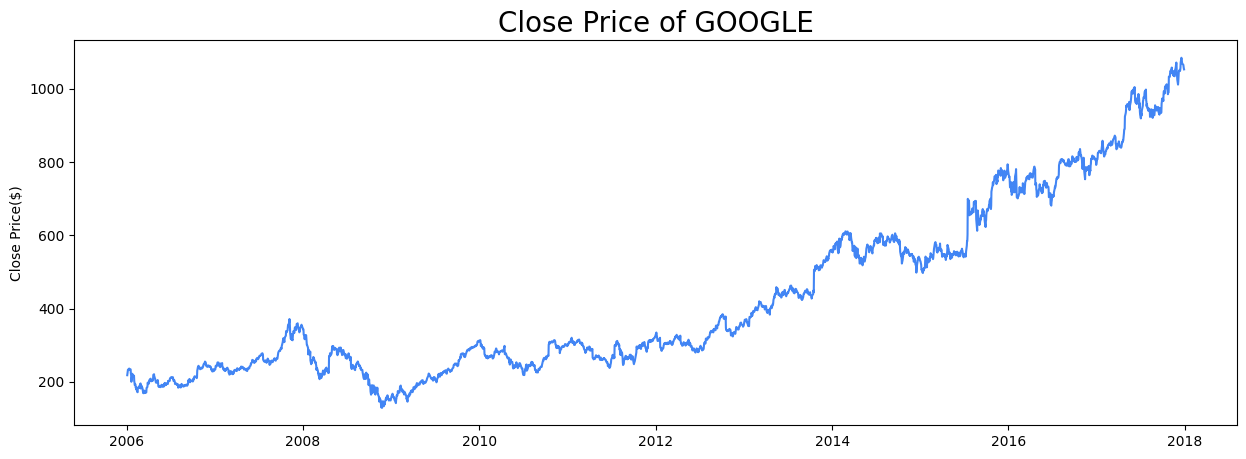

In [8]:
gblue = '#4285F4'
gred = '#DB4437'
gyellow = '#F4B400'
ggreen = '#0F9D58'

plt.figure(figsize=(15,5))
plt.plot(df.index, df['Close'], color=gblue)
plt.ylabel('Close Price($)')
plt.title('Close Price of GOOGLE',
          fontsize=20)

In [9]:
# normalizing

minmax_scaler = MinMaxScaler(feature_range=(0,1))
data_set_scaled = minmax_scaler.fit_transform(np.array(df['Close']).reshape(-1,1))
data_set_scaled

array([[0.09305195],
       [0.09829122],
       [0.10143897],
       ...,
       [0.97397097],
       [0.96952648],
       [0.96685978]])

In [10]:
print("MAE Treshold: "+ str((data_set_scaled.max()-data_set_scaled.min())*10/100))

MAE Treshold: 0.1


In [11]:
# train_size = int(len(data_set_scaled)*0.8)
# train_data, test_data = data_set_scaled[0:train_size,:], data_set_scaled[train_size:len(data_set_scaled),:1]

In [12]:
# len(train_data), len(test_data)

In [13]:
train_data, test_data = train_test_split(data_set_scaled, test_size=0.2, shuffle=False)

In [14]:
len(train_data), len(test_data)

(2415, 604)

In [15]:
def create_xy_variable(dataset, time_step=1):
  data_x, data_y = [], []
  for i in range(len(dataset)-time_step-1):
    data_x.append(dataset[i:(i + time_step), 0]) # i=0, 0,1,2,3,...,n(time_step - 1)
    data_y.append(dataset[i + time_step, 0])
  return np.array(data_x), np.array(data_y)

In [16]:
x_train, y_train = create_xy_variable(train_data, time_step=60)
x_test, y_test = create_xy_variable(test_data, time_step=60)

In [17]:
x_train.shape, y_train.shape

((2354, 60), (2354,))

In [18]:
# reshape input (x var) to be sample (samples, time_steps, features)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [19]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2354, 60, 1)
(543, 60, 1)
(2354,)
(543,)


In [20]:
y = np.concatenate((y_train, y_test))
y = y.reshape(-1,1)
y = minmax_scaler.inverse_transform(y)
y

array([[ 194.41],
       [ 195.19],
       [ 195.04],
       ...,
       [1065.85],
       [1060.2 ],
       [1055.95]])

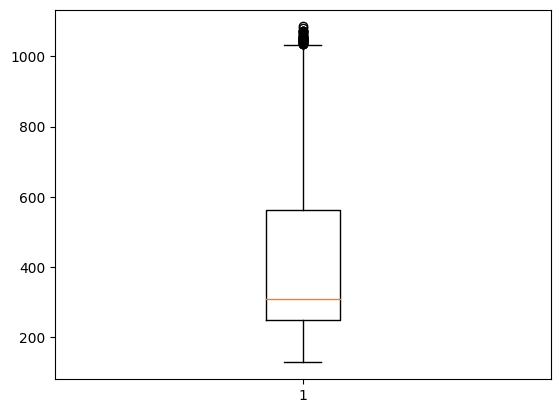

In [21]:
plt.boxplot(y)
plt.show()

In [22]:
# def windowed_dataset(series, shuffle_buffer, window_size = 40, batch_size = 100):
#     series = tf.expand_dims(series, axis=-1)
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
#     ds = ds.flat_map(lambda w: w.batch(window_size + 1))
#     ds = ds.shuffle(shuffle_buffer)
#     ds = ds.map(lambda w: (w[:-1], w[-1:]))
#     return ds.batch(batch_size).prefetch(1)

In [23]:
# x_train_windowed = windowed_dataset(x_train, shuffle_buffer=1000)
# y_train_windowed = windowed_dataset(y_train, shuffle_buffer=1000)
# x_test_windowed = windowed_dataset(x_test, shuffle_buffer=1000)
# y_test_windowed = windowed_dataset(y_test, shuffle_buffer=1000)

In [25]:
model = Sequential()

model.add(LSTM(units=60, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=0.25), metrics=['mean_absolute_error'])
# model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.99),loss=tf.keras.losses.Huber(delta=1), metrics=["mean_absolute_error"])

In [26]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mean_absolute_error')< .02) and (logs.get('val_mean_absolute_error')< .02):
      print('\nMAE is already < 10%!')
      self.model.stop_training = True
callbacks = myCallback()

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=256, verbose=3)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

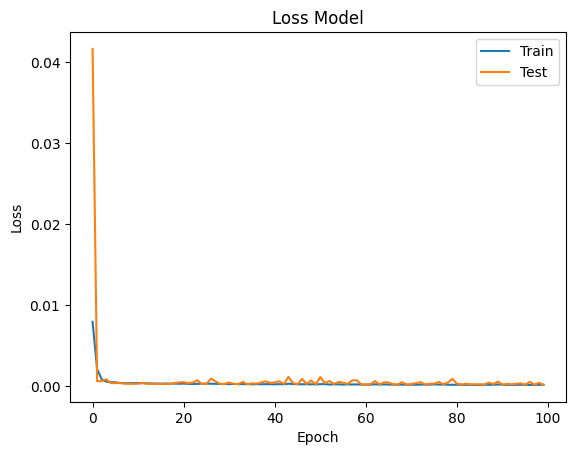

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

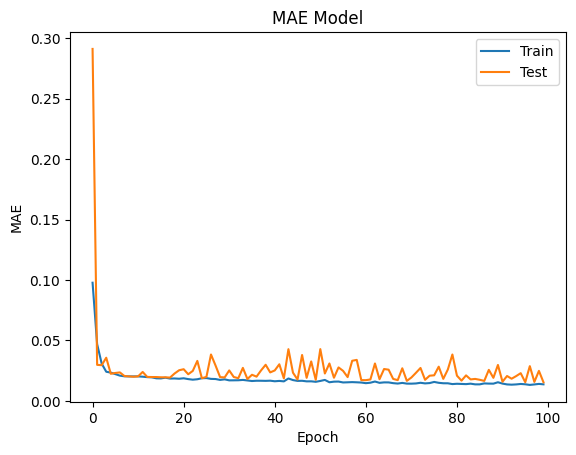

In [28]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE Model')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

PREDICTION

In [29]:
# Lets predict and check the performance metric
train_predict = model.predict(x_train, verbose=3, batch_size=256)
train_predict = minmax_scaler.inverse_transform(train_predict) # transformback to original form
test_predict = model.predict(x_test, verbose=3, batch_size=256)
test_predict = minmax_scaler.inverse_transform(test_predict)

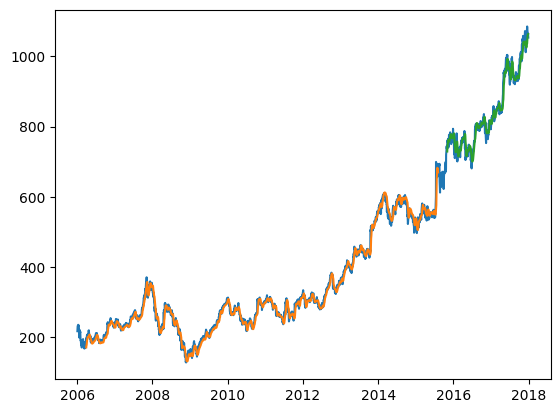

In [65]:
## plotting the prediction accuracy
look_back = 60
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data_set_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_set_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df['Close'])-1, :] = test_predict
# plot actual line and prediction
plt.plot(df.index, minmax_scaler.inverse_transform(data_set_scaled))
plt.plot(df.index, trainPredictPlot)
plt.plot(df.index, testPredictPlot)
plt.show()

In [36]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 60, 1) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
lstm (None, 60, 1) float32
dropout (None, 60, 60) float32
lstm_1 (None, 60, 60) float32
dropout_1 (None, 60, 60) float32
lstm_2 (None, 60, 60) float32
dropout_2 (None, 60) float32
dense (None, 60) float32


[None, None, None, None, None, None, None]

In [33]:
len(test_data)

604

In [34]:
x_input = test_data[544:].reshape(1,-1)
x_input.shape

(1, 60)

In [35]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[0.8955283192503976,
 0.9043650129674561,
 0.902974148749268,
 0.8982577595582699,
 0.9169246214339497,
 0.9169246214339497,
 0.9192462143394966,
 0.9207939429431944,
 0.9225194511838033,
 0.9243390780557184,
 0.9129402660419981,
 0.9163180791433114,
 0.8958943361499205,
 0.8989793357316156,
 0.9020852505647119,
 0.9020434200619092,
 0.9462268886472018,
 0.945662176859366,
 0.9455680582280601,
 0.9555655483978918,
 0.9559524805488164,
 0.9632937337906804,
 0.9556492094034972,
 0.9658035639588392,
 0.9719735631222288,
 0.9609198527566303,
 0.9571864803814945,
 0.9541014807997994,
 0.9545616163306285,
 0.9490922780891828,
 0.9617041746841799,
 0.9485484815527485,
 0.9472621935915673,
 0.9636179201874007,
 0.965312055550908,
 0.9701225633732118,
 0.9863214255835357,
 0.9772023759725592,
 0.950106667782147,
 0.948841295072367,
 0.9372333305446332,
 0.9234292646197608,
 0.9315130092863717,
 0.9452334142056389,
 0.9576257006609221,
 0.9626558186229401,
 0.9653643436794113,
 0.962017903455199

In [37]:
# Lets predict for next 30 days

list_output = []
time_steps = 60
i = 0
while(i<30):
  if(len(temp_input)>60):
    # print(temp_input)
    x_input = np.array(temp_input[1:])
    print('{} day input {}'.format(i, x_input))
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1, time_steps, 1))
    # print(x_input)
    y_output = model.predict(x_input, verbose=3, batch_size=256)
    print('{} day input {}'.format(i, y_output))
    temp_input.extend(y_output[0].tolist())
    temp_input = temp_input[1:]
    # print(temp_input)
    list_output.extend(y_output.tolist())
    i = i+1
  else:
    x_input = x_input.reshape((1, time_steps, 1))
    y_output = model.predict(x_input, verbose=3, batch_size=256)
    print(y_output[0])
    temp_input.extend(y_output[0].tolist())
    print(len(temp_input))
    list_output.extend(y_output.tolist())
    i = i+1

print(list_output)

[0.9734965]
61
1 day input [0.90436501 0.90297415 0.89825776 0.91692462 0.91692462 0.91924621
 0.92079394 0.92251945 0.92433908 0.91294027 0.91631808 0.89589434
 0.89897934 0.90208525 0.90204342 0.94622689 0.94566218 0.94556806
 0.95556555 0.95595248 0.96329373 0.95564921 0.96580356 0.97197356
 0.96091985 0.95718648 0.95410148 0.95456162 0.94909228 0.96170417
 0.94854848 0.94726219 0.96361792 0.96531206 0.97012256 0.98632143
 0.97720238 0.95010667 0.9488413  0.93723333 0.92342926 0.93151301
 0.94523341 0.9576257  0.96265582 0.96536434 0.9620179  0.9647578
 0.97111604 0.98631097 1.         0.994447   0.98794236 0.98510834
 0.98302727 0.97987953 0.97397097 0.96952648 0.96685978 0.9734965 ]
1 day input [[0.97060585]]
2 day input [0.90297415 0.89825776 0.91692462 0.91692462 0.91924621 0.92079394
 0.92251945 0.92433908 0.91294027 0.91631808 0.89589434 0.89897934
 0.90208525 0.90204342 0.94622689 0.94566218 0.94556806 0.95556555
 0.95595248 0.96329373 0.95564921 0.96580356 0.97197356 0.96091

In [38]:
day_new = np.arange(1, 61)
day_predict = np.arange(61, 91)

In [39]:
len(data_set_scaled)

3019

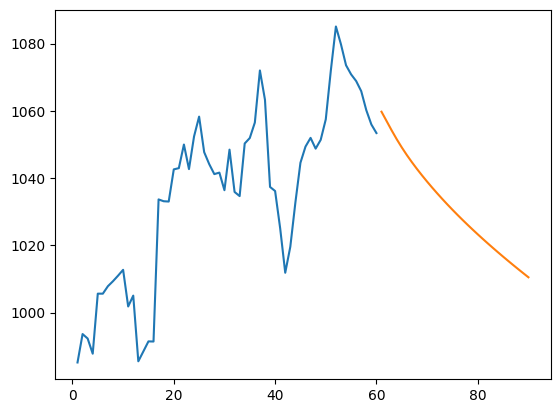

In [46]:
# plot prediction result
plt.plot(day_new, minmax_scaler.inverse_transform(data_set_scaled[2959:]))
plt.plot(day_predict, minmax_scaler.inverse_transform(list_output))

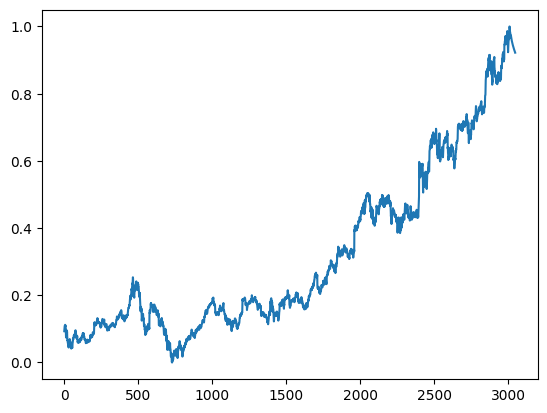

In [61]:
df_fut = data_set_scaled.tolist()
df_fut.extend(list_output)
plt.plot(df_fut)